# Imports

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# Dataset

A gente vai usar um dataset padrão do `scipy`, adicionando algumas variáveis "inventadas" para deixar a brincadeira mais divertida.

In [7]:
boston = datasets.load_boston()

dados = pd.DataFrame(boston['data'], columns = boston['feature_names'])
resposta = pd.DataFrame(boston['target'])

dados.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Adiciona mais variáveis

Criamos uma data falsa

In [8]:
dados['data'] = np.round((dados['B'].rank() + np.random.randint(0, 506, 506)) / 15, 0)
data_backup = dados['data']

Aplicamos algumas transformações aleatórias para criar variáveis adicionais.

In [9]:
def transforma_coluna(s1):
    func = np.random.choice([np.sqrt, np.log, np.sin, np.cos, np.tan, np.abs])
    values = func(abs(s1) * np.random.uniform() + 0.001)
    values[np.abs(values) == np.inf] = np.nan
    return values

def injeta_nulos(s1):
    rand = np.random.random(len(s1))
    s1_copy = s1
    s1_copy[rand < np.random.random() * 0.18] = np.nan
    return s1_copy

def mistura_colunas(s1, s2):
    r = np.random.randint(0, 4)
    if r == 0:
        return injeta_nulos(s1) + injeta_nulos(s2)
    if r == 1:
        return injeta_nulos(s1) * injeta_nulos(s2)
    if r == 2:
        return injeta_nulos(s1) / injeta_nulos(s2)
    if r == 3:
        return np.round(injeta_nulos(s1), 0)

for n in range(200):
    c1 = np.random.choice(dados.columns)
    c2 = np.random.choice(dados.columns)
    c1 = np.random.uniform() * transforma_coluna(dados[c1])
    c2 = np.random.uniform() * transforma_coluna(dados[c2])
    dados[str(np.random.uniform())] = mistura_colunas(c1, c2)

In [10]:
dados.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,data,0.4607937933949702,0.4440620943054069,0.7754802841456432,0.13062151343121808,0.8959536910308933,0.5361830100917718,0.9033347250363192,0.3378480211879402,0.36783956606993184,0.4197699863397565,0.06916760757535534,0.12384950942728046,0.4058791199684727,0.46257172757664966,0.7857721269214067,0.18695709082343115,0.9280135905534618,0.8430321186294145,0.8218720763022795,0.6731787101350083,0.6943191002490742,0.8995535776802613,0.8123776045778284,0.20476398844541543,0.27364401431558383,0.277949724045629,...,0.3584949239290566,0.5537749601720131,0.06977214323666447,0.3927875152459275,0.1940144764647802,0.8501033716960221,0.8149341832277385,0.7240178651380615,0.7355772565641228,0.4018093290656445,0.7281131323435147,0.32189738287491576,0.5045571017803526,0.7645899903561009,0.8412825519515487,0.5511320574563663,0.1496039377268521,0.5556581381245956,0.9360150526269875,0.7345084360863986,0.8698045907282458,0.5860346569052098,0.7623245687336655,0.19673067395022859,0.9444343419694908,0.6577726885385993,0.29869232326766804,0.5799296312609841,0.3883699679198729,0.4599337016531245,0.8585941775676331,0.27906878586085626,0.74558242794984,0.49799217675932483,0.110312768114188,0.9058553518360547,0.5879138413965168,0.2133460555469009,0.8830201195367178,0.9723935632437203
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,48.0,3.023215,-0.0,11.180394,7.997629,384.858062,-0.0,0.007513,19.306980,2.416995,NaN,0.327040,NaN,1.301082,NaN,NaN,NaN,3.098567,0.000160,2.122409,-0.000015,-0.0,0.193550,NaN,NaN,2.994171,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-497.234585,NaN,NaN,0.0,NaN,0.602488,NaN,NaN,NaN,-0.0,NaN,-5.853143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.908516,0.731815,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,40.0,0.623089,-0.0,11.180394,7.809833,649.191628,1.0,NaN,NaN,NaN,0.499214,0.606110,0.063909,3.862289,0.014111,-0.002016,-0.001134,NaN,0.006174,NaN,-0.006942,NaN,0.285112,5801.814156,-0.716444,3.891097,NaN,...,NaN,NaN,NaN,-0.149322,NaN,NaN,NaN,NaN,-528.377496,NaN,NaN,0.0,NaN,NaN,12.0,NaN,NaN,-0.0,NaN,-2.526581,NaN,NaN,NaN,NaN,16.507466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,NaN,NaN,NaN
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,27.0,0.697068,-0.0,11.122923,7.793241,649.191628,NaN,0.002580,7.827188,1.207384,-0.620682,NaN,0.064074,3.844976,0.013916,-0.001993,-0.001134,0.623027,NaN,1.070268,NaN,NaN,0.285112,3853.232198,-0.548332,3.891097,0.002214,...,NaN,NaN,0.270124,NaN,0.382602,2.344347,NaN,0.005244,-528.377496,1.480587,NaN,NaN,NaN,NaN,10.0,NaN,NaN,-0.0,9.464204,NaN,NaN,NaN,NaN,NaN,19.113938,NaN,NaN,NaN,NaN,0.717543,-0.139869,-1.279562,NaN,NaN,0.0,3.0,NaN,NaN,NaN,NaN
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,55.0,0.678961,-0.0,NaN,7.805103,-1544.393466,1.0,-0.004767,NaN,0.563479,NaN,0.794536,NaN,NaN,0.014056,NaN,NaN,NaN,NaN,0.510188,NaN,NaN,0.391534,3291.551425,NaN,NaN,0.003771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-542.102704,NaN,NaN,0.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.461680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,40.0,0.693388,-0.0,11.180394,7.831222,-1544.393466,1.0,0.009097,19.307297,-7.755912,4.965924,NaN,0.062368,3.259513,0.014362,NaN,-0.000360,4.274871,0.007534,6.766296,-0.006942,-0.0,0.391534,4430.987431,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.622140,11.0,NaN,NaN,NaN,11.008487,-2.212728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,NaN,NaN,NaN


## Treino e Teste

In [11]:
ids_treino = list(np.random.choice(dados.index, int(500 * 0.7), replace=False))
ids_teste = [id for id in dados.index if id not in ids_treino]

dados_treino = dados.loc[ids_treino, ]
resposta_treino = resposta.loc[ids_treino, ]
dados_teste = dados.loc[ids_teste, ]
resposta_teste = resposta.loc[ids_teste, ]

dados_treino.shape, resposta_treino.shape, dados_teste.shape, resposta_teste.shape

((350, 214), (350, 1), (156, 214), (156, 1))

# Filtering

## Nulos

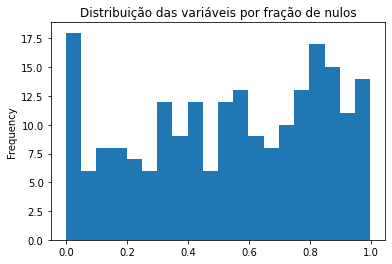

In [12]:
contagem_de_nulos = dados_treino.isna().mean()

contagem_de_nulos.plot.hist(bins=20)
plt.title("Distribuição das variáveis por fração de nulos")
plt.show()

In [13]:
remover_nulos = contagem_de_nulos[contagem_de_nulos >= 0.95].index
selecionadas = [var for var in dados_treino.columns if var not in remover_nulos]

len(remover_nulos)

13

In [14]:
dados_treino = dados_treino[selecionadas]
dados_teste = dados_teste[selecionadas]

## Baixa Variância

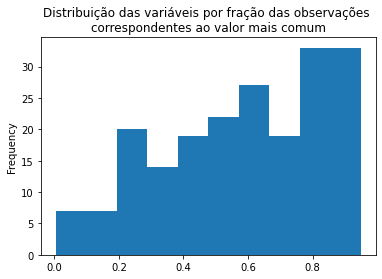

In [15]:
val_unicos = dados_treino.apply(lambda x: x.value_counts(dropna=False).values[0] / len(dados_treino), axis=0)

val_unicos.plot.hist()
plt.title("Distribuição das variáveis por fração das observações \ncorrespondentes ao valor mais comum")
plt.show()

In [16]:
remover_cat_dominante = val_unicos[val_unicos >= 0.95].index
selecionadas = [var for var in dados_treino.columns if var not in remover_cat_dominante]

len(remover_cat_dominante)

0

In [17]:
dados_treino = dados_treino[selecionadas]
dados_teste = dados_teste[selecionadas]

Para olhar para a variância, e não só para valores repetidos, precisamos primeiro colocar os dados na mesma escala.

In [18]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
dados_mesma_escala = min_max_scaler.fit_transform(dados_treino)
dados_mesma_escala = pd.DataFrame(dados_mesma_escala, columns=dados_treino.columns)

In [19]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.01)
dados_mesma_escala = selector.fit_transform(dados_mesma_escala)

remover_variancia = dados_treino.columns[~selector.get_support()]
selecionadas = [var for var in dados_treino.columns if var not in remover_variancia]

len(remover_variancia)

44

In [20]:
dados_treino = dados_treino[selecionadas]
dados_teste = dados_teste[selecionadas]

## Correlação

In [21]:
correlacao = dados_treino.corr()

Correlações (ordenadas para ficar mais visível e bonito)

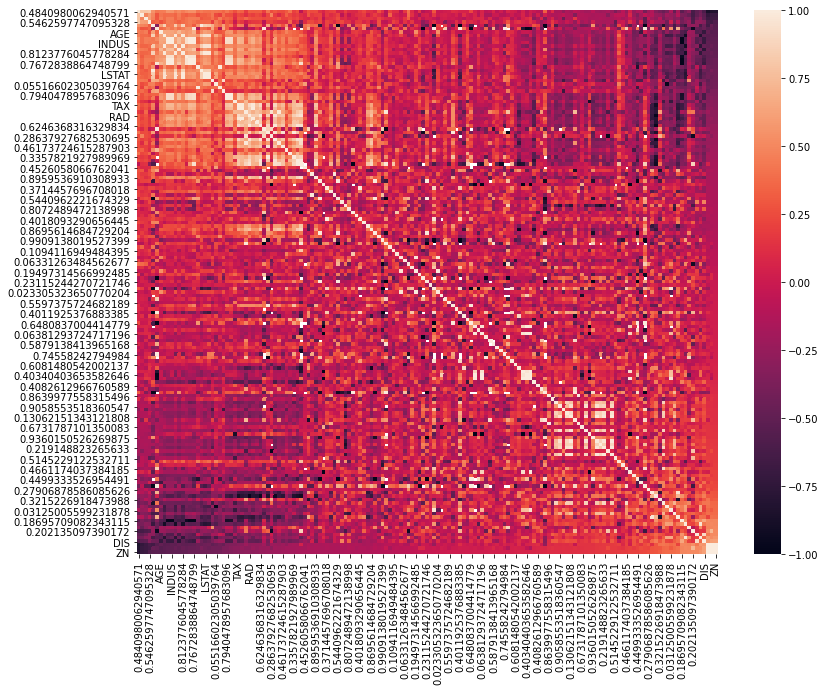

In [22]:
correlacao = correlacao.sort_values(by=correlacao.columns[0], axis=0).sort_values(by=correlacao.columns[0], axis=1)

plt.figure(figsize=(13, 10))
sns.heatmap(correlacao)
plt.show()

Vamos ordenar as variáveis por cobertura para que as variáveis removidas sejam sempre as de menor cobertura:

In [23]:
ordem = list(dados_treino.isna().mean().sort_values().index)

correlacao = correlacao.loc[ordem, ordem].abs()

superior = correlacao.where(np.triu(np.ones(correlacao.shape), k=1).astype(np.bool))

remover_correlacao = [column for column in superior.columns if any(superior[column] > 0.95)]
selecionadas = [var for var in dados_treino.columns if var not in remover_correlacao]

len(remover_correlacao)

55

In [24]:
dados_treino = dados_treino[selecionadas]
dados_teste = dados_teste[selecionadas]

In [25]:
dados_treino.shape, dados_teste.shape

((350, 102), (156, 102))

# SF embutida

## Lasso

O primeiro passo é fazer imputação de 0s já que esse método não suporta nulos. Para não se complicar nesse tutorial, vamos usar 0 para tudo.

In [26]:
dados_treino_lasso = dados_treino.copy()
dados_treino_lasso = dados_treino_lasso.fillna(0)

Modelos lineares também se beneficiam de colocar as variáveis na mesma escala. Dessa vez não tem problema de normalizar.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dados_treino_lasso)

dados_treino_lasso_norm = scaler.transform(dados_treino_lasso)

Vamos treinar um modelo de Lasso:

In [28]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(dados_treino_lasso_norm, resposta_treino)

pd.DataFrame({"feature": dados_treino_lasso.columns, "coeficiente_lasso": lasso.coef_}).sort_values('coeficiente_lasso', ascending=False).head(20)

,feature,coeficiente_lasso
4,RM,2.901604
10,B,0.871523
7,RAD,0.619616
0,ZN,0.618711
45,0.7673912912076715,0.545283
62,0.12980993864867818,0.499525
31,0.15645762715976397,0.481476
57,0.5781613777574908,0.475273
2,CHAS,0.425302
101,0.5879138413965168,0.379751


Podemos também fazer uma validação cruzada bonita aqui para achar o melhor parâmetro `alpha`.

In [29]:
from sklearn.linear_model import LassoCV

fit = LassoCV(random_state=0).fit(dados_treino_lasso_norm, np.array(resposta_treino).flatten())

In [30]:
fit.alpha_

0.20213968974336075

In [31]:
pd.DataFrame({"feature": dados_treino_lasso.columns, "coeficiente_lasso": fit.coef_}).sort_values('coeficiente_lasso', ascending=False).head(20)

,feature,coeficiente_lasso
4,RM,3.028188
10,B,0.665876
57,0.5781613777574908,0.439267
0,ZN,0.421006
31,0.15645762715976397,0.352250
2,CHAS,0.333161
62,0.12980993864867818,0.326306
101,0.5879138413965168,0.293480
53,0.6632340108314626,0.238255
29,0.10584192717584928,0.082272


# Wrappers

## Floresta Aleatória

Um exemplo simples de seleção de variáveis.

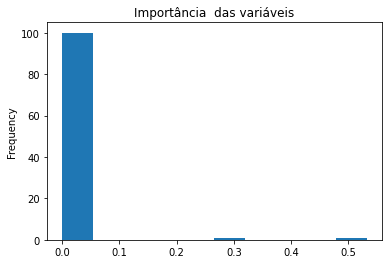

In [32]:
from sklearn.ensemble import RandomForestRegressor

dados_treino_rf = dados_treino.copy()
dados_treino_rf = dados_treino_rf.fillna(0)

dados_teste_rf = dados_teste.copy()
dados_teste_rf = dados_teste_rf.fillna(0)

model = RandomForestRegressor(n_estimators=100)
model.fit(dados_treino_rf, np.array(resposta_treino).flatten())

importances = model.feature_importances_

pd.Series(importances).plot.hist()
plt.title("Importância  das variáveis")
plt.show()

In [33]:
from sklearn.metrics import r2_score

treino_r2 = []
teste_r2 = []
variaveis = []

vars_selecionadas = dados_treino.columns

for i in range(len(dados_treino.columns)):
    model = RandomForestRegressor(n_estimators=10)
    model.fit(dados_treino_rf[vars_selecionadas], np.array(resposta_treino).flatten())
    
    importancias = model.feature_importances_
    remover = pd.Series(importancias, index=vars_selecionadas).sort_values().index[0]

    treino_r2.append(r2_score(model.predict(dados_treino_rf[vars_selecionadas]), resposta_treino))
    teste_r2.append(r2_score(model.predict(dados_teste_rf[vars_selecionadas]), resposta_teste))
    variaveis.append(vars_selecionadas)

    vars_selecionadas = [f for f in vars_selecionadas if f != remover]

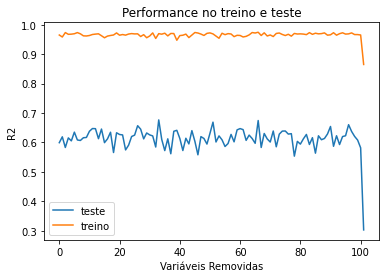

In [34]:
df=pd.DataFrame({"teste": teste_r2, "treino": treino_r2})#.rolling(5, min_periods=1).mean()
df.plot()
plt.title("Performance no treino e teste")
plt.xlabel("Variáveis Removidas")
plt.ylabel("R2")
plt.show()

In [35]:
ordem = dados_treino.corr().sum().abs().sort_values(ascending=False).index

In [36]:
ordem

Index(['RAD', '0.7240178651380615', '0.27364401431558383', 'TAX',
       '0.3357821927989969', '0.13802378402118576', '0.7621566233843393',
       '0.9750700068516991', '0.7940478957683096', '0.4840980062940571',
       ...
       '0.1094116949484395', '0.7673912912076715', '0.8565542975654825',
       '0.6081480542002137', '0.6119171948450505', '0.5398735211808958',
       '0.5597375724682189', '0.5145229122532711', '0.7345084360863986',
       '0.3927875152459275'],
      dtype='object', length=102)

In [37]:
from sklearn.metrics import r2_score

treino_r2 = []
teste_r2 = []
variaveis = []

vars_selecionadas = dados_treino.columns

for i in range(len(dados_treino.columns)):
    model = RandomForestRegressor(n_estimators=10)
    model.fit(dados_treino_rf[vars_selecionadas], np.array(resposta_treino).flatten())
    
    # importancias = model.feature_importances_
    remover = ordem[i]

    treino_r2.append(r2_score(model.predict(dados_treino_rf[vars_selecionadas]), resposta_treino))
    teste_r2.append(r2_score(model.predict(dados_teste_rf[vars_selecionadas]), resposta_teste))
    variaveis.append(vars_selecionadas)

    vars_selecionadas = [f for f in vars_selecionadas if f != remover]

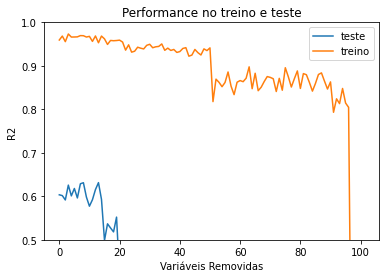

In [38]:
df=pd.DataFrame({"teste": teste_r2, "treino": treino_r2})#.rolling(5, min_periods=1).mean()
df.plot()
plt.title("Performance no treino e teste")
plt.xlabel("Variáveis Removidas")
plt.ylabel("R2")
plt.ylim([0.5, 1.0])
plt.show()

## Importâncias Shap

In [39]:
!pip install shap

In [40]:
import shap
from xgboost import XGBRegressor

In [41]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(dados_treino, np.array(resposta_treino).flatten())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

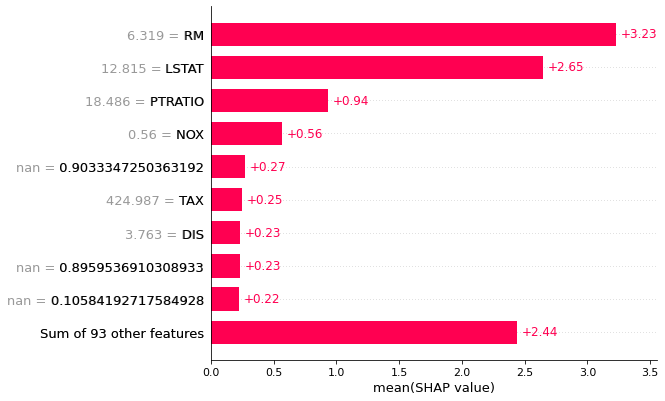

In [42]:
exp = shap.TreeExplainer(model)
shap_vals = exp(dados_teste)
expected_value = exp.expected_value

shap.plots.bar(shap_vals)

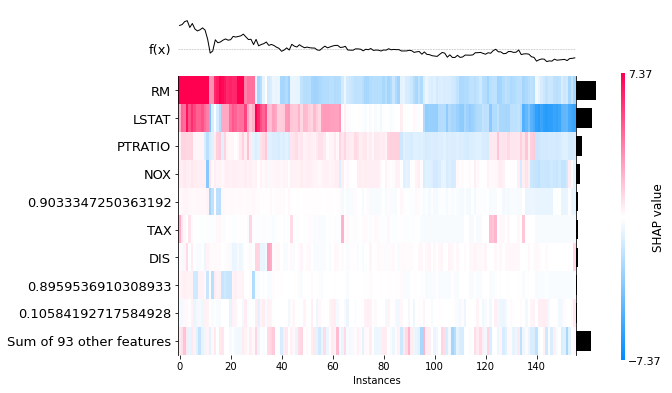

In [43]:
shap.plots.heatmap(shap_vals)

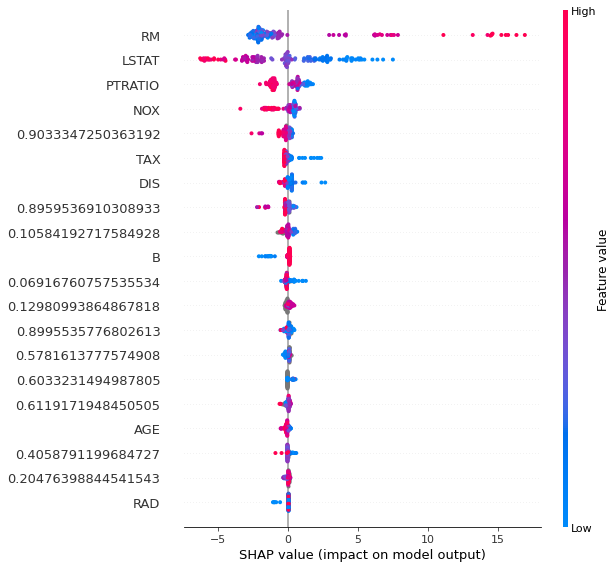

In [44]:
shap.summary_plot(shap_vals.values, dados_teste)

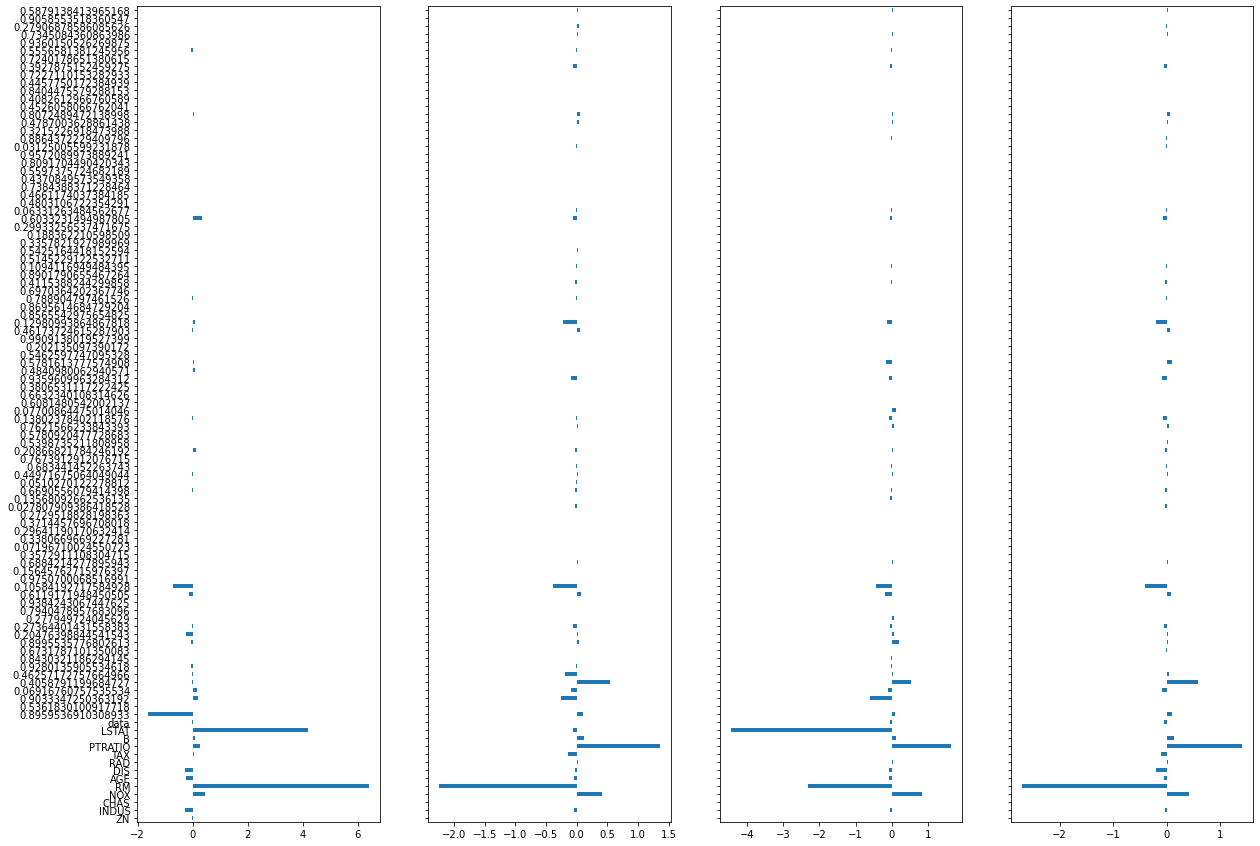

In [45]:
shap_df = pd.DataFrame(shap_vals.values, columns=dados_teste.columns)
fig, ax = plt.subplots(1, 4, figsize=(20,15), sharey=True)

shap_df.iloc[0].plot.barh(ax=ax[0])
shap_df.iloc[1].plot.barh(ax=ax[1])
shap_df.iloc[2].plot.barh(ax=ax[2])
shap_df.iloc[3].plot.barh(ax=ax[3])

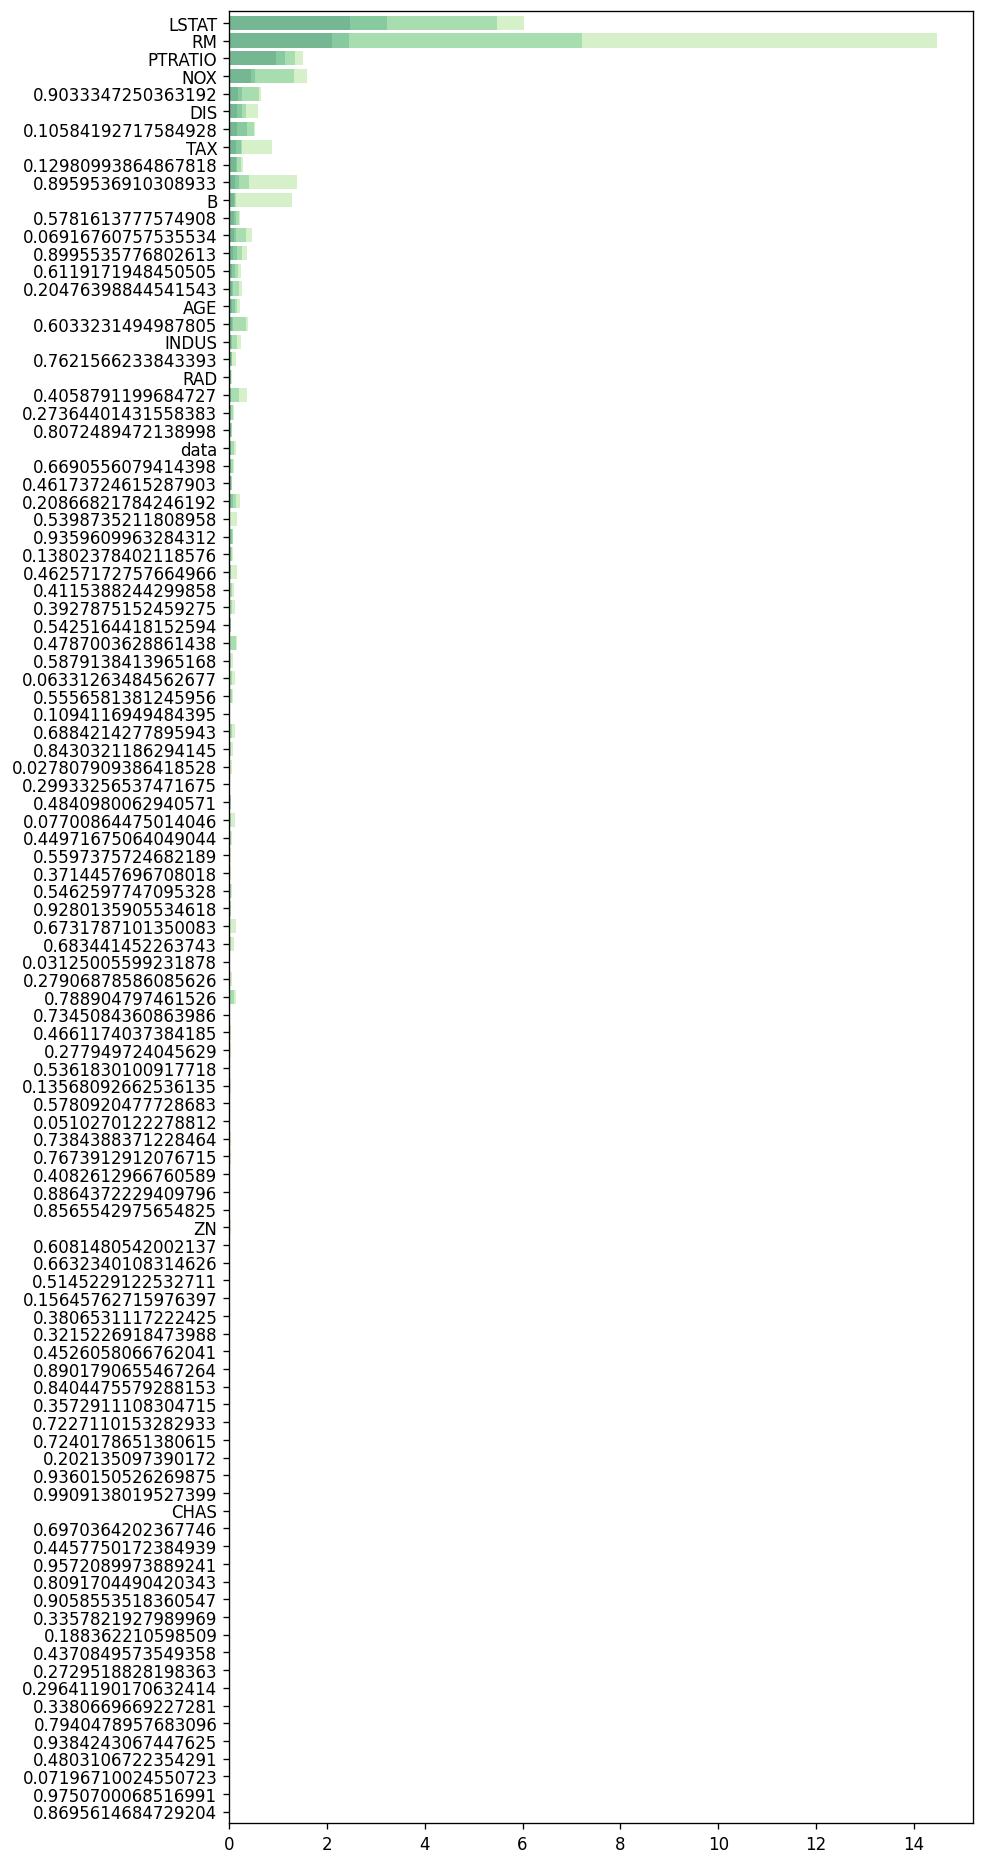

In [46]:
quantiles_df = shap_df.abs().quantile([.5, .7, .9, .95]).T.sort_values(.5, ascending=True)
colors = sns.color_palette('viridis', 4)

plt.figure(figsize=(8,20), dpi=120)
for i, q in enumerate(quantiles_df.columns):
  quantiles_df[q].plot.barh(color=colors[i], alpha=0.3, width=.8)

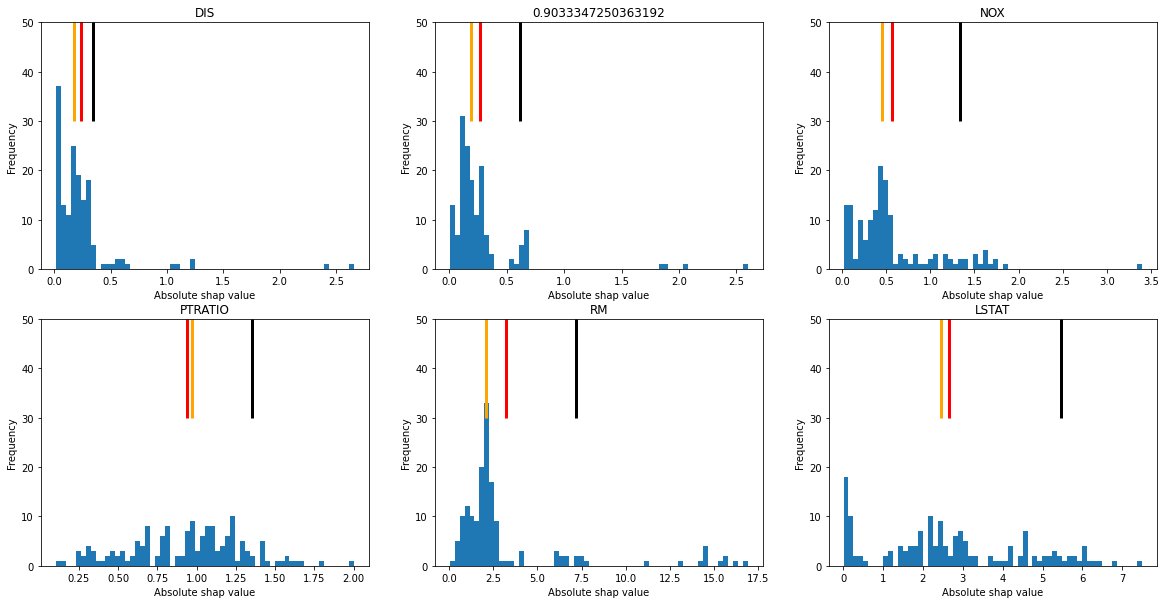

In [47]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
for i, feat in enumerate(quantiles_df.index[-6:]):
  hist = shap_df[feat].abs().plot.hist(bins=60, ax=ax[int(i / 3), i % 3]);            
  ax[int(i / 3), i % 3].set_title(feat)
  ax[int(i / 3), i % 3].vlines([shap_df[feat].abs().mean(), shap_df[feat].abs().median(), shap_df[feat].abs().quantile(.9)], 30, 50, colors=['r','orange','k'], linewidth=3)
  ax[int(i / 3), i % 3].set_ylim(0,50)
  ax[int(i / 3), i % 3].set_xlabel("Absolute shap value")

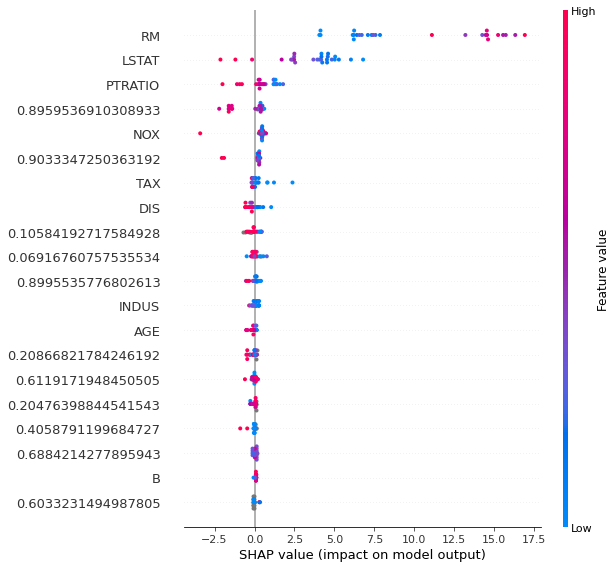

In [48]:
# shap_df

shap.summary_plot(shap_vals.values[shap_df['RM'] > 4], dados_teste[(shap_df['RM'] > 4).values])